In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets
import sklearn.cluster
import sklearn.preprocessing
import sklearn.neural_network
import sklearn.linear_model
import sklearn.model_selection
import torch

In [2]:
data = pd.read_csv( 'data.csv' )
print(np.shape(data))
data.head()

(11500, 180)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [3]:
# del(data['Unnamed: 0'])
data = data.drop(columns = ['Unnamed: 0'])
print(np.shape(data))
data.head()

(11500, 179)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [4]:
data.keys()
X = data[data.keys()[:-1]]
target = data['y']

Y = []
for i in range(len(target)):
    if target[i] == 1:
        Y.append( 1 )
    else:
        Y.append( 0 )

Y = np.array(Y)
print(np.shape(X), np.shape(Y))

(11500, 178) (11500,)


In [5]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3)

scaler = sklearn.preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
X_new = np.expand_dims(X_train, 1) # necesario para que las dimensiones sean [batch, channel, width]
feature_maps = torch.autograd.Variable(torch.Tensor(X_new).float())
print(feature_maps.size())

n = torch.nn.Conv1d(1, 2, 8, stride=1) # in-channels = 1, out-channels = 10, kernel=8
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.MaxPool1d(kernel_size=3)
feature_maps = n(feature_maps)
print(feature_maps.size())

n = torch.nn.Conv1d(2, 1, 2, stride=1)
feature_maps = n(feature_maps)
print(feature_maps.size())

torch.Size([8050, 1, 178])
torch.Size([8050, 2, 171])
torch.Size([8050, 2, 57])
torch.Size([8050, 1, 56])


In [7]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 2, kernel_size=8, stride=1),
    torch.nn.MaxPool1d(kernel_size=3),
    torch.nn.Conv1d(2, 1, kernel_size=2, stride=1),
    torch.nn.Linear(56, 2)
)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) #lr: learning rate
epochs = 60
loss_values = np.zeros(epochs)
F1_values_train = np.zeros(epochs)
F1_values_test = np.zeros(epochs)


for epoch in range(epochs):
    X_new = np.expand_dims(X_train, 1) 
    inputs = torch.autograd.Variable(torch.Tensor(X_new).float())
    targets = torch.autograd.Variable(torch.Tensor(Y_train).long())
    
    optimizer.zero_grad()
    out = model(inputs)
    out = out.squeeze(dim=1) # necesario para quitar la dimension intermedia de channel
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    
    values, Y_predicted = torch.max(out.data, 1)
    loss_values[epoch] = loss.item()
    F1_values_train[epoch] = sklearn.metrics.f1_score(Y_train, Y_predicted, average='macro')
    
    X_new = np.expand_dims(X_test, 1)
    inputs_test = torch.autograd.Variable(torch.Tensor(X_new).float())
    out_test = model(inputs_test)
    out_test = out_test.squeeze(dim=1)
    values, Y_predicted_test = torch.max(out_test.data, 1)
    F1_values_test[epoch] = sklearn.metrics.f1_score(Y_test, Y_predicted_test, average='macro')

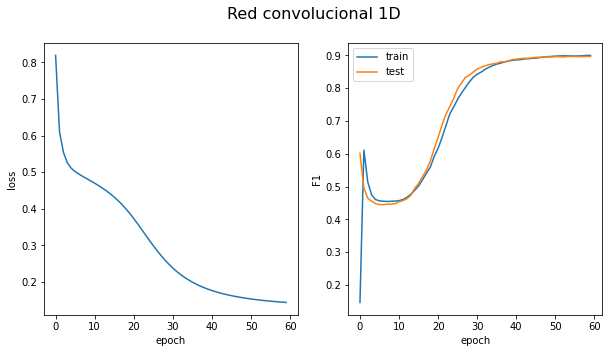

In [8]:
plt.figure(figsize=(10,5))
plt.suptitle('Red convolucional 1D', fontsize=16)

plt.subplot(1,2,1)
plt.plot(np.arange(epochs), loss_values)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(np.arange(epochs), F1_values_train, label='train')
plt.plot(np.arange(epochs), F1_values_test, label='test')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend( )

plt.subplots_adjust(hspace=.5)
plt.savefig( 'loss_f1_convolucional_1D.png' )
plt.show()